**Table of contents**<a id='toc0_'></a>    
- [Prophet Model](#toc1_1_)    
    - [Prophet Tuned Model](#toc1_1_1_)    
    - [Facebook Prophet Analysis](#toc1_1_2_)    
      - [Preparing Data for Prophet](#toc1_1_2_1_)    
    - [Recurrent Neural Networks (RNNs)](#toc1_1_3_)    
      - [Data Preprocessing for RNNs](#toc1_1_3_1_)    
      - [Building and Training the RNN](#toc1_1_3_2_)    
      - [Predictions and Evaluation](#toc1_1_3_3_)    
- [Code of the dead](#toc2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Prophet Model](#toc0_)
- Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.
    - Datetime column named: `ds`
    - target : `y`

In [1]:
from capstone_functions import *
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

# Set the random.seed(42)
np.random.seed(42)


Versions used in this notebook:
Python version: 3.9.17 (main, Jul  5 2023, 21:22:06) [MSC v.1916 64 bit (AMD64)]
Pandas version: 2.0.2
Numpy version: 1.23.4
Seaborn version: 0.12.2
Matplotlib version: 3.7.1
Scipy version: 1.10.1
Statsmodels version: 0.14.0
SKLearn version: 1.2.2


C:\Users\Samsickle\AppData\Local\Temp\ipykernel_32168\1022261773.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
from prophet.plot import plot_cross_validation_metric, plot_plotly
import statsmodels.api as sm
from prophet.serialize import model_to_json, model_from_json
from prophet.diagnostics import cross_validation, performance_metrics
import scipy.stats as stats
import itertools


In [3]:
master_df = pd.read_parquet("../Data/master_df.parquet")

#prepare the data for prophet
master_df = master_df.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}).copy()

master_df.info()
master_df.head()

cutoff_period_prediction = 60

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1131 entries, 0 to 1130
Data columns (total 67 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   ds                                    1131 non-null   datetime64[ns]
 1   y                                     1131 non-null   int32         
 2   new_fatal                             1131 non-null   int32         
 3   confirmed                             1131 non-null   int32         
 4   fatal                                 1131 non-null   int32         
 5   infected                              1131 non-null   int32         
 6   new_recovered                         1131 non-null   int32         
 7   recovered                             1131 non-null   int32         
 8   total_removed                         1131 non-null   int32         
 9   new_hospitalized_patients             944 non-null    float32       
 10  

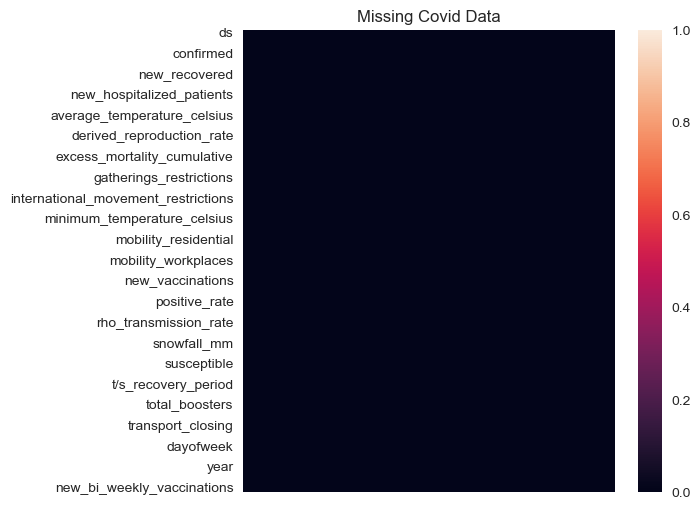

(855, 67)

In [4]:
no_null_rows = master_df.dropna().copy()

#heat map to see how much values need to updated
plt.figure(figsize=(6,6))
sns.heatmap(no_null_rows.isna().T,xticklabels = [], vmin=0, vmax=1)
plt.title("Missing Covid Data")
plt.show()

no_null_rows.shape

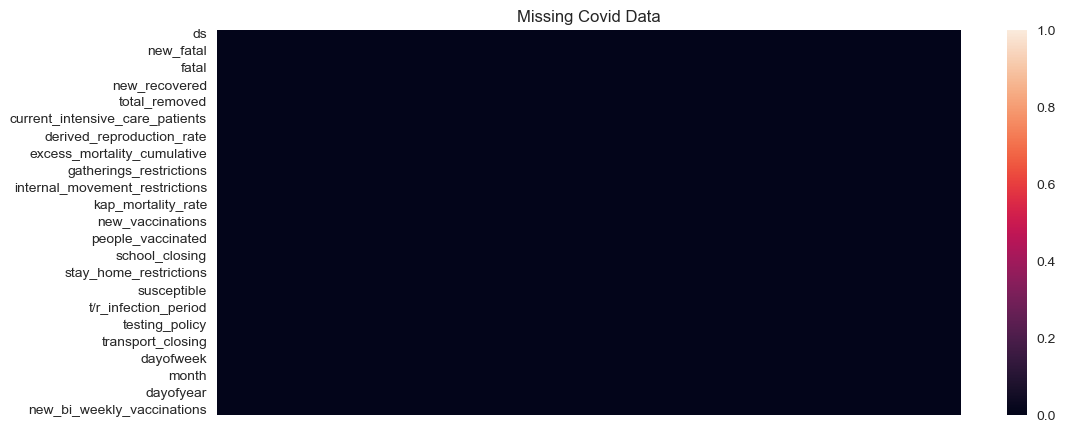

(1131, 45)

In [5]:
no_null_col = master_df.dropna(axis=1).copy()

#heat map to see how much values need to updated
plt.figure(figsize=(12,5))
sns.heatmap(no_null_col.isna().T,xticklabels = [], vmin=0, vmax=1)
plt.title("Missing Covid Data")
plt.show()

no_null_col.shape

In [6]:
no_null_rows = master_df.dropna().copy()

no_null_col = master_df.dropna(axis=1).copy()

cutoff= cutoff_period_prediction
cutoff_date = no_null_col.ds.max() - pd.Timedelta(days=cutoff)

train_df = no_null_col[no_null_col.ds < cutoff_date].copy()
test_df = no_null_col[no_null_col.ds >= cutoff_date].copy()


In [7]:
y_train = train_df[['ds','y']].copy()
y_test = test_df[['ds','y']].copy()


most_important = ['stringency_index', 'derived_reproduction_rate', 'new_bi_weekly_vaccinations', 
                'current_hospitalized_patients',  'excess_mortality', 'ds']

X_train = train_df[most_important].copy()
X_test = test_df[most_important].copy()

val_eval_holder = pd.DataFrame().rename_axis('Validation Metric', axis=1)
in_sample_eval_holder = pd.DataFrame().rename_axis('In-Sample Metric', axis=1)
out_of_sample_eval_holder = pd.DataFrame().rename_axis('Out-of-Sample Metric', axis=1)


## Base Model of Prophet

In [8]:
def residual_plotter(forecast_df, yhat_col='yhat', original_col='y_train'):
    """
    Plots residual diagnostics and returns evaluation metrics for a forecast dataframe from Prophet.
    
    Parameters:
    - forecast_df: DataFrame from Prophet prediction.
    
    Returns:
    - scores: Series with R2, MAE, RMSE, and SMAPE scores.
    """
    
    # Calculate residuals and lags
    residuals = (forecast_df[original_col] - forecast_df[yhat_col]).dropna()
    lags = int(min(20, round(len(residuals)/3) - 1))
    
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))

    # Plot Histogram
    sns.histplot(residuals, kde=True,  ax=ax[0,0])
    ax[0,0].set_title("Histogram of Residuals")
    ax[0,0].set_xlabel("Residual")
    ax[0,0].set_ylabel("Frequency")
    ax[0,0].grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # QQ Plot
    stats.probplot(residuals, dist="norm", plot=ax[0,1])
    ax[0,1].set_title("Q-Q Plot of Residuals")
    ax[0,1].grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # ACF and PACF plots
    sm.graphics.tsa.plot_acf(residuals, lags=lags, ax=ax[1,0])
    sm.graphics.tsa.plot_pacf(residuals, lags=lags, ax=ax[1,1])
    
    ax[1,0].set_title("ACF of Residuals")
    ax[1,1].set_title("PACF of Residuals")
    plt.tight_layout()
    plt.show()
    
        
    # Evaluation Metrics
    r2 = r2_score(forecast_df[original_col], forecast_df[yhat_col])
    mae = mean_absolute_error(forecast_df[original_col], forecast_df[yhat_col])
    rmse = mean_squared_error(forecast_df[original_col], forecast_df[yhat_col], squared=False)
    smape_score = smape(forecast_df[original_col], forecast_df[yhat_col])
    
    scores = pd.Series({
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse,
        'SMAPE': smape_score
    })
    
    return scores #, residuals

# residual_plotter(forecast_df.dropna(subset='y_train'), yhat_col='yhat', original_col='y_train')
# residual_plotter(forecast_df.dropna(subset='y_test'), yhat_col='yhat', original_col='y_test')


In [9]:
def forecast_df_complete(model, y_train, y_test, exogenous_df=None):

    prophet_model_df = model.make_future_dataframe(cutoff_period_prediction, freq='D', include_history=True)
    
    if master_df is not None:
        prophet_model_df = prophet_model_df.merge(master_df, on='ds', how='left')

    forecast_df = model.predict(prophet_model_df)
    
    
    forecast_df = forecast_df.merge(y_train, on='ds', how='left').copy()
    forecast_df = forecast_df.merge(y_test, on='ds', how='left', suffixes = ['_train', '_test']).copy()
    
    
    return forecast_df

In [10]:

model = Prophet().fit(y_train)


forecast_df = forecast_df_complete(model, y_train, y_test)


# Generate the Prophet forecast plot
fig = plot_plotly(model, forecast_df)

# Add the test actual data points
fig.add_trace(go.Scatter(
    x=y_test.ds, 
    y=y_test.y, 
    mode='lines', 
    name='Historical Predictions', 
    line=dict(color='green')
))

# Add titles and labels
fig.update_layout(
    title="Prophet Model Forecast vs Actual Data",
    xaxis_title="Date",
    yaxis_title="Value",
    legend_title="Legend"
)

# Display the plot
fig.show();


08:46:35 - cmdstanpy - INFO - Chain [1] start processing
08:46:35 - cmdstanpy - INFO - Chain [1] done processing


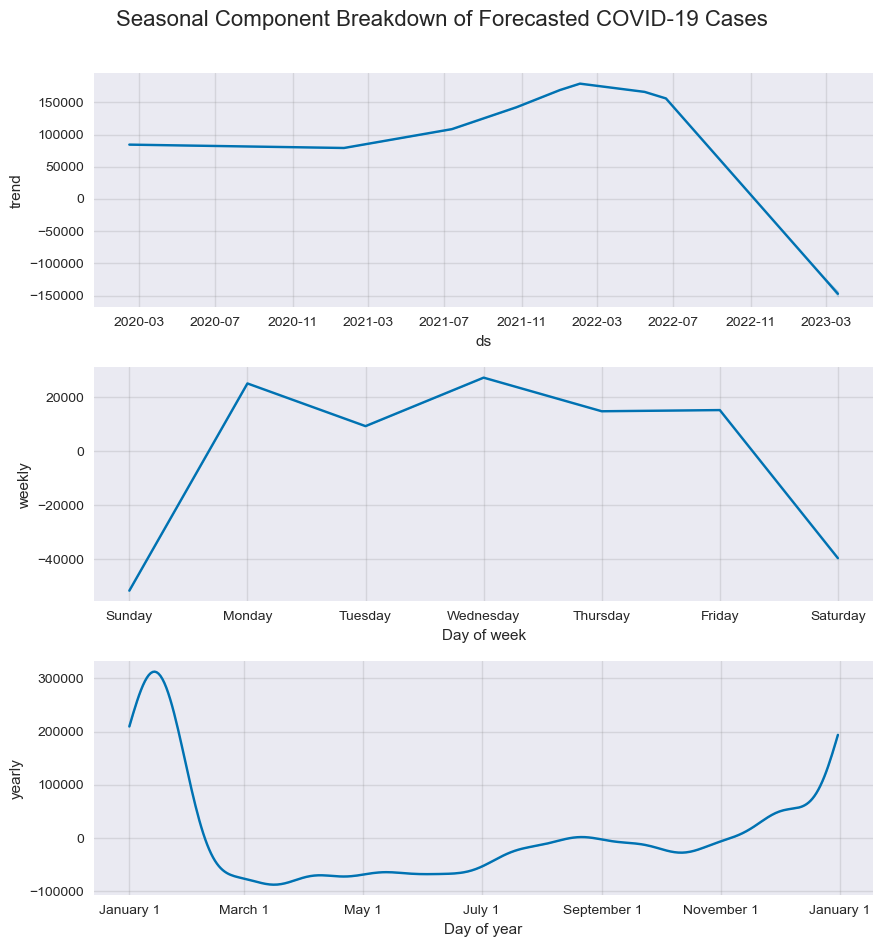

In [11]:

fig = model.plot_components(forecast_df)
fig.suptitle('Seasonal Component Breakdown of Forecasted COVID-19 Cases', y=1.05, fontsize=16)
fig.show();
# Using the function on the sample dataframe


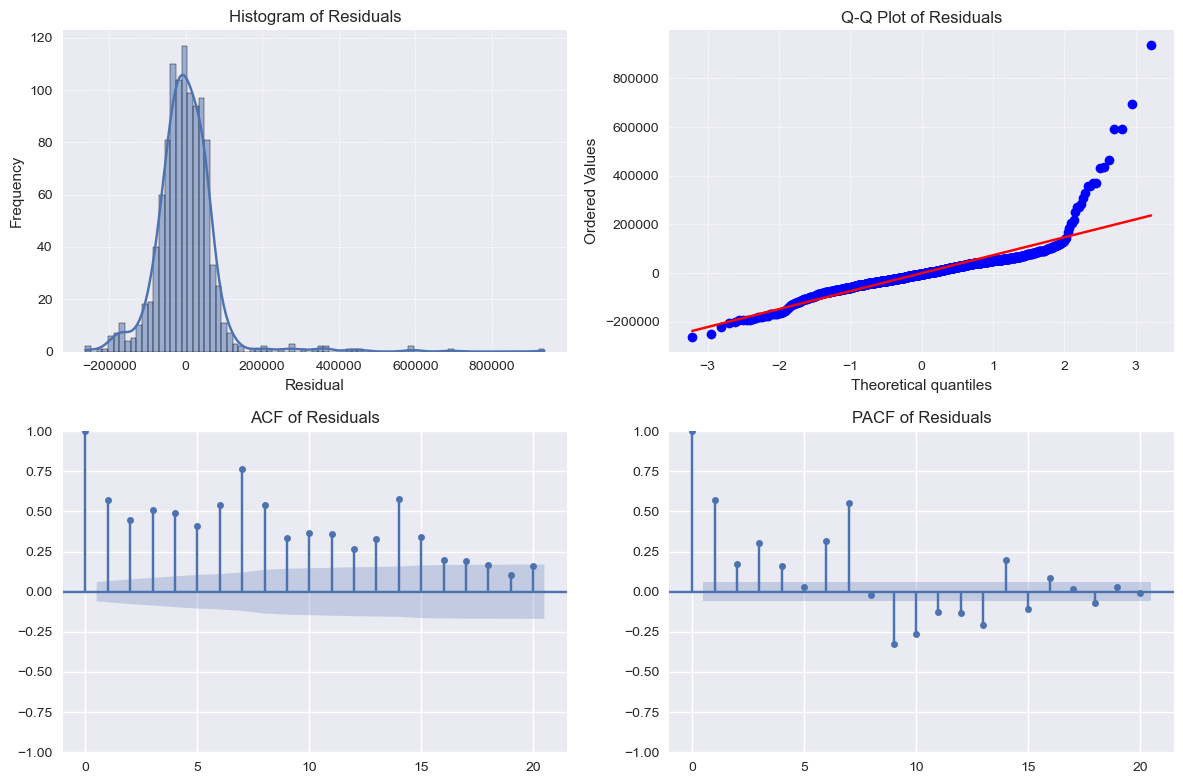

In [12]:

in_sample_eval_holder['Base Prophet Model'] = residual_plotter(forecast_df.dropna(subset='y_train'), yhat_col='yhat', original_col='y_train')


In [13]:
val_eval_holder

Validation Metric


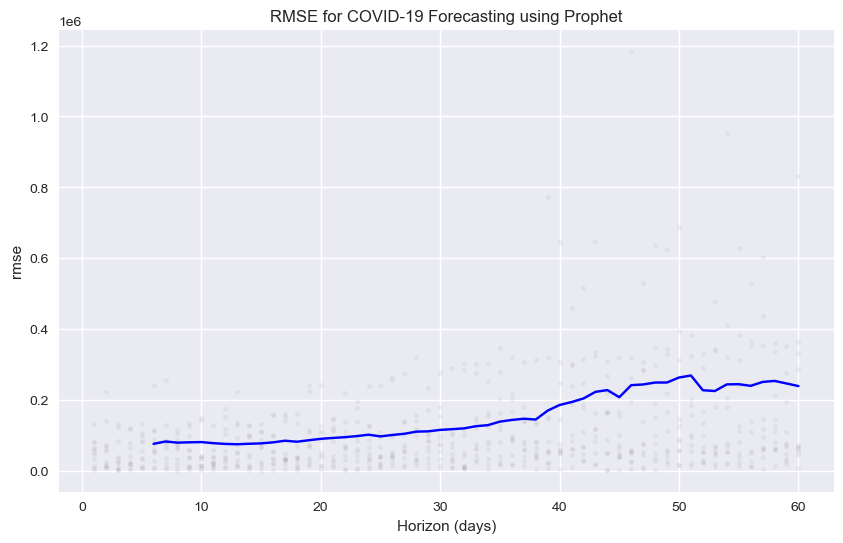

In [14]:



df_cv = cross_validation(
    model, 
    initial=f"366 days", 
    period=f"{cutoff_period_prediction} days", 
    horizon=f"{cutoff_period_prediction} days",
    parallel="processes")

val_eval_holder['Base Prophet Model'] = pd.to_numeric(performance_metrics(df_cv).mean().drop(index='horizon'))

plot_cross_validation_metric(df_cv, metric='rmse')

plt.title('RMSE for COVID-19 Forecasting using Prophet');


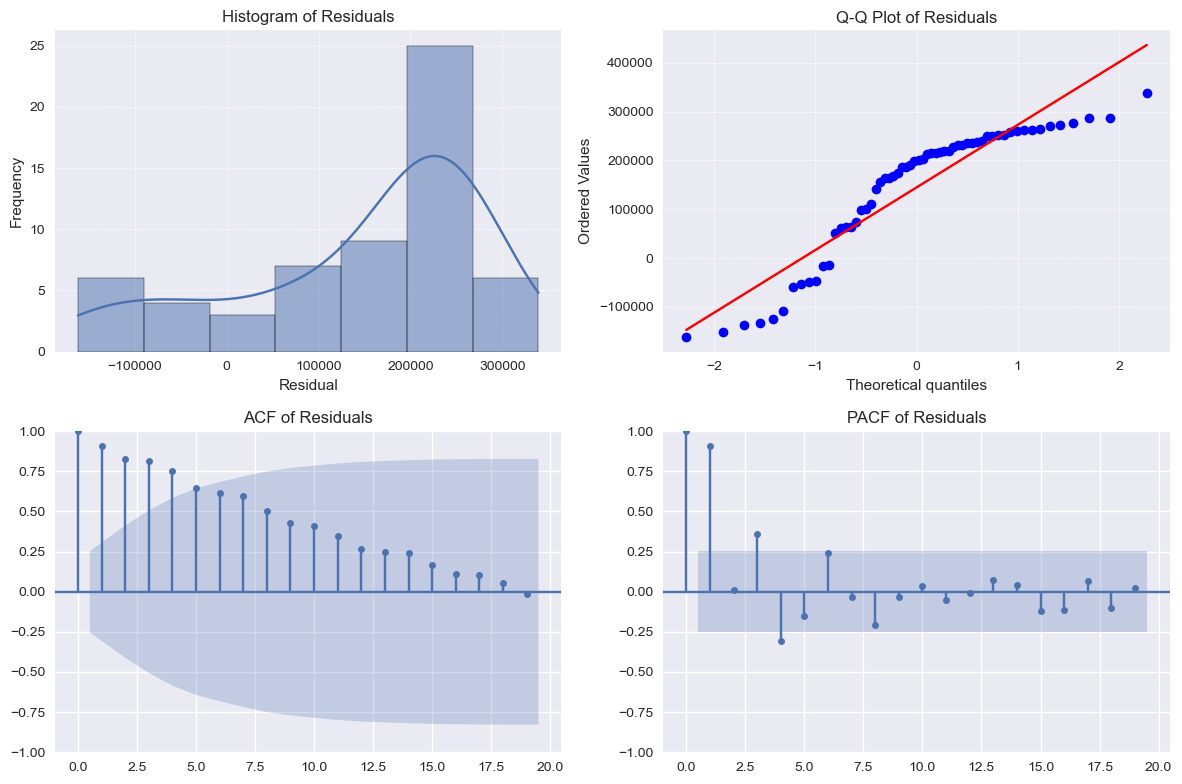

In [15]:


out_of_sample_eval_holder['Base Prophet Model'] = residual_plotter(forecast_df.dropna(subset='y_test'), yhat_col='yhat', original_col='y_test')


# with open('serialized_model.json', 'w') as fout:
#     fout.write(model_to_json(model))  # Save model

# with open('serialized_model.json', 'r') as fin:
#     model = model_from_json(fin.read())  # Load model


In [16]:
display(val_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
display(in_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
# display(out_of_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))

Validation Metric,Base Prophet Model
mse,28160621499.734882
rmse,153148.176498
mae,108432.555908
mdape,1.038325
smape,0.900018
coverage,0.484573


In-Sample Metric,Base Prophet Model
R2,0.593939
MAE,51705.436286
RMSE,83698.449913
SMAPE,73.923349


### <a id='toc1_1_1_'></a>[Prophet Tuned Model](#toc0_)

In [17]:
brute_force = False

In [18]:
if brute_force:
    # Python
    import itertools

    param_grid = {  
        'changepoint_prior_scale': np.logspace(-2.5,-1.5, 5),
        'seasonality_prior_scale': np.logspace(-1.5,1, 5),
        
    }

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    rmses = []  # Store the RMSEs for each params here
    mae = []
    smape = []
    coverage = []


    # Use cross validation to evaluate all parameters
    for params in all_params:    
        m = Prophet(**params).fit(y_train)  # Fit model with given params
        
        df_cv = cross_validation(
            m, 
            initial=f"366 days", 
            period=f"{cutoff_period_prediction}", 
            horizon=f"{cutoff_period_prediction}",
            parallel="processes")

        
        df_p = performance_metrics(df_cv, rolling_window=29)
        rmses.append(df_p['rmse'].values[0])
        mae.append(df_p['mae'].values[0])
        smape.append(df_p['smape'].values[0])
        coverage.append(df_p['coverage'].values[0])
        
    # Find the best parameters

    tuning_results1 = pd.DataFrame(all_params)
    tuning_results1['rmse'] = rmses
    tuning_results1['mae'] = mae
    tuning_results1['smape'] = smape
    tuning_results1['coverage'] = coverage


08:46:41 - cmdstanpy - INFO - Chain [1] start processing
08:46:41 - cmdstanpy - INFO - Chain [1] done processing


KeyboardInterrupt: 

In [ ]:
if brute_force:
    best_params = all_params[np.argmin(rmses)]
    print(best_params)


    tuning_results1['compo'] = (tuning_results['rmse'] + tuning_results1['mae']) * tuning_results1['smape']

    tuning_results1.sort_values(by='changepoint_prior_scale').style.background_gradient(cmap='coolwarm', subset=['smape','mae', 'rmse', 'compo'])

{'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 2.371373705661655}


NameError: name 'tuning_results' is not defined

In [ ]:
if brute_force:
    param_grid = {  
        'changepoint_prior_scale': np.logspace(-2, -1, 7),
        'seasonality_prior_scale': np.logspace(-2, 2, 7),
    }

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    rmses = []  # Store the RMSEs for each params here
    mae = []
    smape = []
    coverage = []

    # Use cross validation to evaluate all parameters
    for params in all_params:    
        m = Prophet(**params).fit(y_train)  # Fit model with given params
        
        df_cv = cross_validation(
            m, 
            initial=f"366 days", 
            period=f"{cutoff_period_prediction}", 
            horizon=f"{cutoff_period_prediction}",
            parallel="processes")

        df_p = performance_metrics(df_cv, rolling_window=29)
        rmses.append(df_p['rmse'].values[0])
        mae.append(df_p['mae'].values[0])
        smape.append(df_p['smape'].values[0])
        coverage.append(df_p['coverage'].values[0])

    # Find the best parameters

    tuning_results = pd.DataFrame(all_params)
    tuning_results['rmse'] = rmses
    tuning_results['mae'] = mae
    tuning_results['smape'] = smape
    tuning_results['coverage'] = coverage



In [ ]:
if brute_force:
    best_params = all_params[np.argmin(rmses)]
    print(best_params)


    tuning_results['compo'] = ((tuning_results['rmse'] + tuning_results['mae']) / 2) / y_train.std()[1]
    tuning_results['compo2'] = (tuning_results['rmse'] + tuning_results['mae']) * tuning_results['smape'] / y_train.std()[1]

    tuning_results.sort_values(by='compo').head(15).style.background_gradient(cmap='coolwarm', subset=['smape','mae', 'rmse', 'compo', 'compo2'])


In [ ]:

model2 = Prophet(changepoint_prior_scale = 0.031623, seasonality_prior_scale = 0.046416)
model2.add_country_holidays(country_name='US')

model2.fit(y_train)
# changepoint_prior_scale = 0.031623
# seasonality_prior_scale = 0.046416

forecast_df = forecast_df_complete(model2, y_train, y_test)


# Generate the Prophet forecast plot
fig = plot_plotly(model2, forecast_df)

# Add the test actual data points
fig.add_trace(go.Scatter(
    x=y_test.ds, 
    y=y_test.y, 
    mode='lines', 
    name='Historical Predictions', 
    line=dict(color='green')
))

# Add titles and labels
fig.update_layout(
    title="Tuned Prophet Model Forecast vs Actual Data",
    xaxis_title="Date",
    yaxis_title="Value",
    legend_title="Legend"
)

# Display the plot
fig.show();


05:40:57 - cmdstanpy - INFO - Chain [1] start processing
05:40:57 - cmdstanpy - INFO - Chain [1] done processing


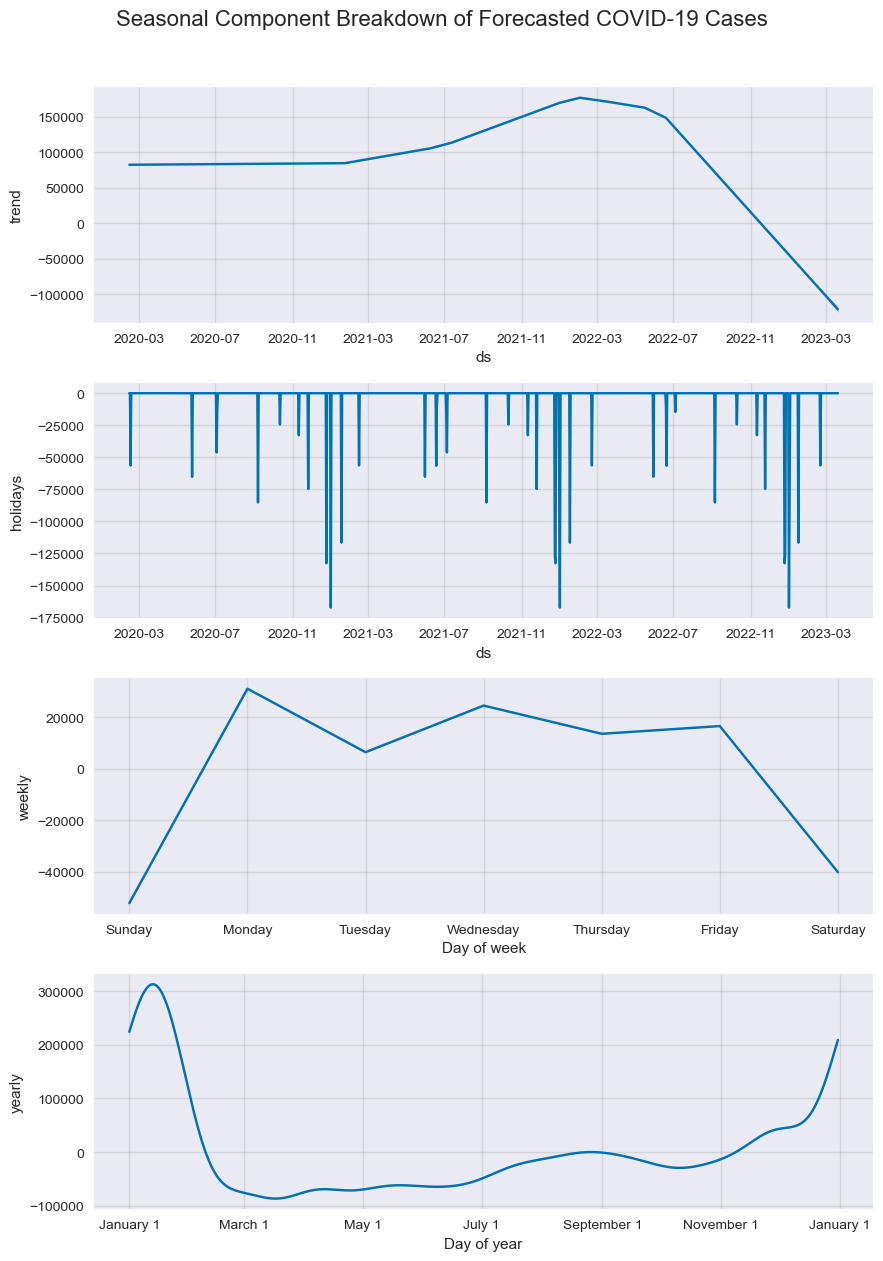

In [ ]:

fig = model2.plot_components(forecast_df)
fig.suptitle('Seasonal Component Breakdown of Forecasted COVID-19 Cases', y=1.05, fontsize=16)
fig.show();
# Using the function on the sample dataframe


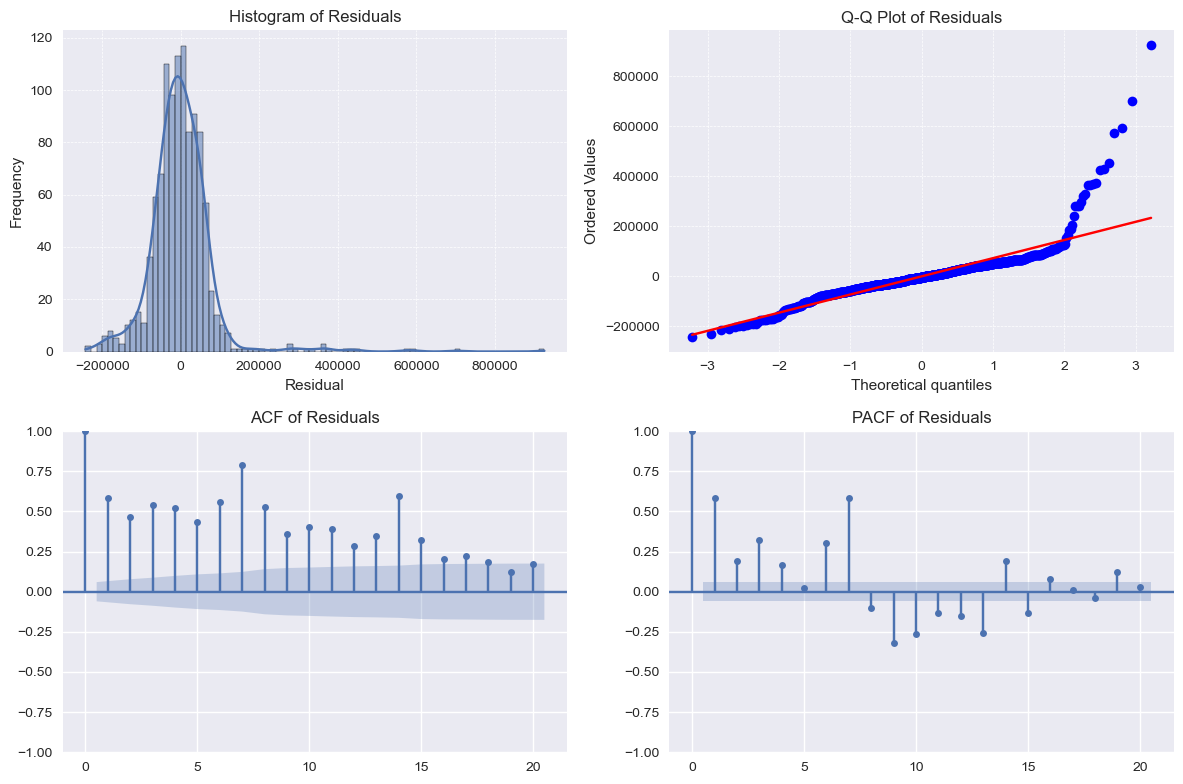

In [ ]:

in_sample_eval_holder['Tuned Prophet Model'] = residual_plotter(forecast_df.dropna(subset='y_train'), yhat_col='yhat', original_col='y_train')


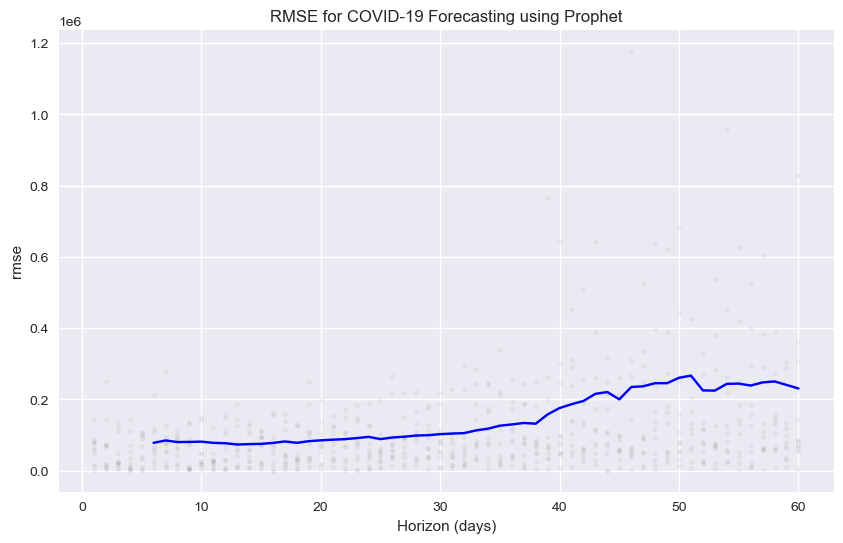

In [ ]:

df_cv = cross_validation(
    model2, 
    initial=f"366 days", 
    period=f"{cutoff_period_prediction} days", 
    horizon=f"{cutoff_period_prediction} days",
    parallel="processes")

val_eval_holder['Tuned Prophet Model'] = pd.to_numeric(performance_metrics(df_cv).mean().drop(index='horizon'))

plot_cross_validation_metric(df_cv, metric='rmse')

plt.title('RMSE for COVID-19 Forecasting using Prophet');


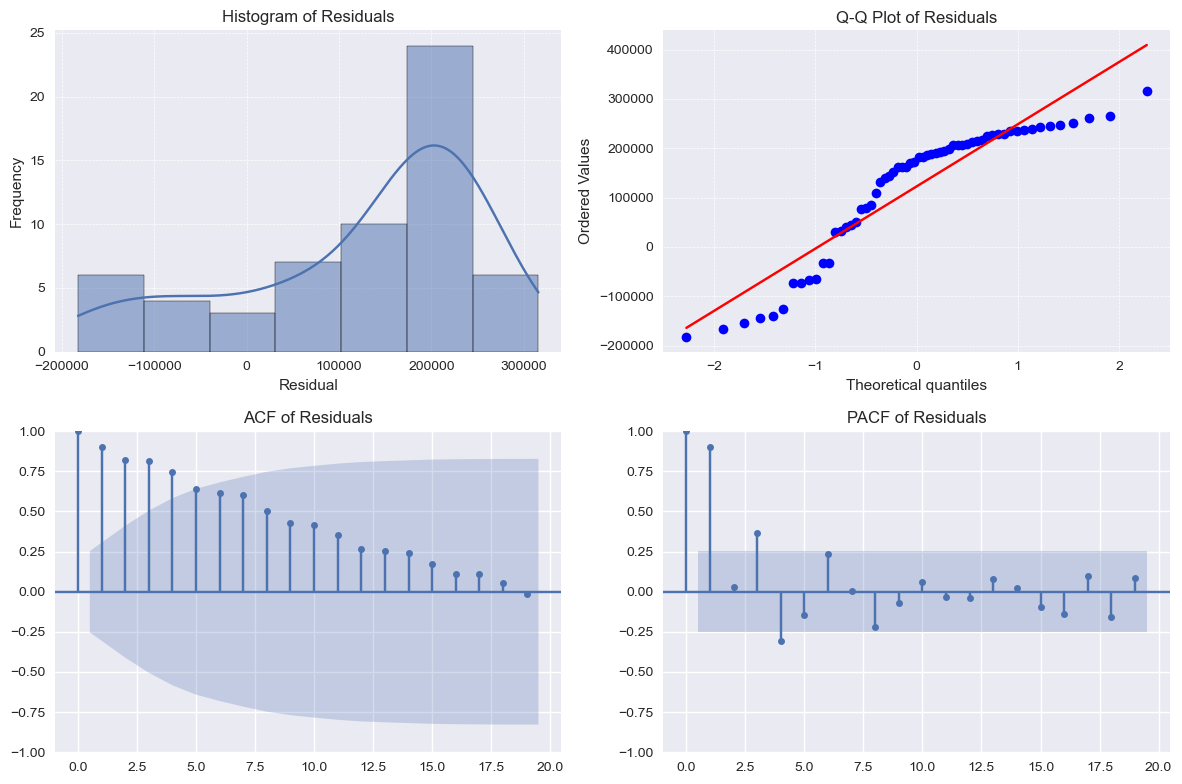

In [ ]:


out_of_sample_eval_holder['Tuned Prophet Model'] = residual_plotter(forecast_df.dropna(subset='y_test'), yhat_col='yhat', original_col='y_test')


# with open('serialized_model.json', 'w') as fout:
#     fout.write(model_to_json(model))  # Save model

# with open('serialized_model.json', 'r') as fin:
#     model = model_from_json(fin.read())  # Load model


In [ ]:
display(val_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
display(in_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
# display(out_of_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))

Validation Metric,Base Prophet Model,Tuned Prophet Model
mse,28160621499.734882,26365675445.739998
rmse,153148.176498,147088.321667
mae,108432.555908,104166.787212
mdape,1.038325,1.011090
smape,0.900018,0.901866
coverage,0.489807,0.465840


In-Sample Metric,Base Prophet Model,Tuned Prophet Model
R2,0.593939,0.601912
MAE,51705.436286,50744.964617
RMSE,83698.449913,82872.623110
SMAPE,73.923349,73.046986



### <a id='toc1_1_2_'></a>[Facebook Prophet Analysis](#toc0_)

Facebook Prophet is designed for forecasting time series data. Let's see how we can use it.


In [20]:

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.feature_selection import RFE


In [21]:

everything_df = train_df.drop(columns=['y','ds'])
train_df = no_null_col[no_null_col.ds < cutoff_date].copy()
test_df = no_null_col[no_null_col.ds >= cutoff_date].copy()


In [22]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(X_train_full):
    # Drop columns: 'current_hospitalized_patients', 'current_intensive_care_patients' and 20 other columns
    columns_to_keep = ['current_hospitalized_patients', 'current_intensive_care_patients', 'cancel_events', 'derived_reproduction_rate', 
                'excess_mortality', 'gatherings_restrictions', 'information_campaigns', 'internal_movement_restrictions', 'international_movement_restrictions', 
                'school_closing', 'sig_recovery_rate', 'stay_home_restrictions', 'stringency_index', 'testing_policy', 'transport_closing', 'workplace_closing', 
                'dayofweek', 'quarter', 'month', 'new_bi_weekly_vaccinations', 'fatal', 'kap_mortality_rate']
    
    
    X_train_full = X_train_full.loc[:, columns_to_keep]
    return X_train_full


# 'susceptible'

X_train_full = clean_data(everything_df.copy())
X_train_full.head()

,current_hospitalized_patients,current_intensive_care_patients,cancel_events,derived_reproduction_rate,excess_mortality,gatherings_restrictions,information_campaigns,internal_movement_restrictions,international_movement_restrictions,school_closing,sig_recovery_rate,stay_home_restrictions,stringency_index,testing_policy,transport_closing,workplace_closing,dayofweek,quarter,month,new_bi_weekly_vaccinations,fatal,kap_mortality_rate
0,0.0,0.0,0.0,35.466824,-2.363827,0.0,0.0,0.0,3.0,0.0,0.000097,0.0,8.33,1.0,0.0,0.0,5,1,2,0.0,0,0.000149
1,0.0,0.0,0.0,34.655106,-2.360000,0.0,0.0,0.0,3.0,0.0,0.000097,0.0,8.33,1.0,0.0,0.0,6,1,2,0.0,0,0.000155
2,0.0,0.0,0.0,33.889042,-2.294236,0.0,0.0,0.0,3.0,0.0,0.000097,0.0,8.33,1.0,0.0,0.0,0,1,2,0.0,0,0.000161
3,0.0,0.0,0.0,33.163906,-2.166535,0.0,0.0,0.0,3.0,0.0,0.000097,0.0,8.33,1.0,0.0,0.0,1,1,2,0.0,0,0.000167
4,0.0,0.0,0.0,32.475555,-1.976897,0.0,0.0,0.0,3.0,0.0,0.000097,0.0,8.33,1.0,0.0,0.0,2,1,2,0.0,0,0.000172


In [23]:
X_train_full.columns

X_train_full = add_constant(X_train_full)

#  VIF values
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_full.columns

# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train_full.values, i) for i in range(X_train_full.shape[1])]
display(vif_data.sort_values(by='VIF', ascending=False).style.background_gradient(cmap='coolwarm', vmax=10))


X_train_full.drop(columns=['const'], inplace=True)

,Feature,VIF
0,const,1010.172337
13,stringency_index,181.057303
2,current_intensive_care_patients,63.217998
21,fatal,56.610790
1,current_hospitalized_patients,38.766007
5,excess_mortality,25.741341
6,gatherings_restrictions,24.076618
18,quarter,23.256109
12,stay_home_restrictions,21.099081
19,month,20.975947


In [24]:
if brute_force:
    # Python

    param_grid = {  
        'changepoint_prior_scale': np.logspace(-2.5,-1.5, 4),
        'seasonality_prior_scale': np.logspace(-1.5,1, 4),
        'holidays_prior_scale': np.logspace(-2,1, 4),
    }

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    rmses = []  # Store the RMSEs for each params here
    mae = []
    smape = []
    coverage = []


    # Use cross validation to evaluate all parameters
    for params in tqdm(all_params):    
        m = Prophet(**params) # Fit model with given params
        m.add_country_holidays(country_name='US')

        for i in X_train_full.columns:
            m.add_regressor(i, prior_scale = .5, standardize='auto', mode='additive')

        m.fit(pd.concat([X_train_full, y_train], axis=1))

        df_cv = cross_validation(
            m, 
            initial=f"366 days", 
            period=f"{cutoff_period_prediction} days", 
            horizon=f"{cutoff_period_prediction} days",
            parallel="processes")

        
        df_p = performance_metrics(df_cv, rolling_window=29)
        rmses.append(df_p['rmse'].values[0])
        mae.append(df_p['mae'].values[0])
        smape.append(df_p['smape'].values[0])
        coverage.append(df_p['coverage'].values[0])
        
    # Find the best parameters

    tuning_results1 = pd.DataFrame(all_params)
    tuning_results1['rmse'] = rmses
    tuning_results1['mae'] = mae
    tuning_results1['smape'] = smape
    tuning_results1['coverage'] = coverage

    tuning_results1

    best_params = all_params[np.argmin(rmses)]
    print(best_params)


    tuning_results1['compo'] = (tuning_results1['rmse'] + tuning_results1['mae']) * tuning_results1['smape']

    tuning_results1.sort_values(by='rmse').style.background_gradient(cmap='coolwarm', subset=['smape','mae', 'rmse', 'compo', 'coverage'])

  0%|          | 0/64 [00:00<?, ?it/s]

08:47:18 - cmdstanpy - INFO - Chain [1] start processing
08:47:18 - cmdstanpy - INFO - Chain [1] done processing
08:47:22 - cmdstanpy - INFO - Chain [1] start processing
08:47:23 - cmdstanpy - INFO - Chain [1] done processing
08:47:26 - cmdstanpy - INFO - Chain [1] start processing
08:47:26 - cmdstanpy - INFO - Chain [1] done processing
08:47:30 - cmdstanpy - INFO - Chain [1] start processing
08:47:30 - cmdstanpy - INFO - Chain [1] done processing
08:47:34 - cmdstanpy - INFO - Chain [1] start processing
08:47:35 - cmdstanpy - INFO - Chain [1] done processing


KeyboardInterrupt: 

In [ ]:
# exog_train = pd.merge(X_train, y_train, on = ['ds'])

# exog_test = pd.merge(X_test, y_test, on = ['ds'])


# model3 = Prophet(changepoint_prior_scale = 0.031623, seasonality_prior_scale = 0.046416)

# for i in X_train.columns[:-2]:
#     model3.add_regressor(i, prior_scale=0.5, mode='additive')

# model3.fit(exog_train)



# title= 'Prophet Tuned and Sparse Exogenous Model 1'

In [ ]:
# model3 = Prophet(changepoint_prior_scale = 0.031623, seasonality_prior_scale = 0.046416, growth='flat')
# model3.add_country_holidays(country_name='US')

# for i in X_train_full.columns:
#     model3.add_regressor(i, prior_scale = .5, standardize='auto', mode='additive')

# model3.fit(pd.concat([X_train_full, y_train], axis=1))


# title= 'Prophet Tuned and Big Exogenous Model 2'

In [ ]:
# big_ready = pd.concat([y_train, X_train_full], axis=1).copy()
# big_ready.iloc[:,1:] = big_ready.iloc[:,1:].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna(axis=0, how='any').copy()

# model3 = Prophet(changepoint_prior_scale = 0.003162, seasonality_prior_scale = 0.215443, holidays_prior_scale = 0.100000, growth='flat')
# model3.add_country_holidays(country_name='US')

# for i in big_ready.columns[2:]:
#     model3.add_regressor(i, prior_scale = .5, standardize='auto', mode='additive')

# model3.fit(big_ready)

# title = 'Prophet Super Tuned and Big Exogenous Model 3'

08:46:07 - cmdstanpy - INFO - Chain [1] start processing
08:46:07 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# everything_df = train_df.drop(columns=['y','ds'])
# everything_df.drop(columns=['confirmed', 'susceptible', 'fatal', 'infected', # removed 4
#                             'excess_mortality', 'total_removed', 'dayofmonth', # removed 7
#                             'excess_mortality_cumulative', 'excess_mortality_cumulative_absolute', 'people_fully_vaccinated', 'people_vaccinated', #removed 11
#                             'transport_closing', 'workplace_closing', 'dayofweek', 'quarter', # removed 15
#                             'derived_reproduction_rate', 'cancel_events', 'gatherings_restrictions',  
#                             'information_campaigns', 'internal_movement_restrictions', # removed 20
#                             't/k_mortality_period', 't/r_infection_period', 't/s_recovery_period', # removed 23
                            
#                             # 'sig_recovery_rate', 'rho_transmission_rate', 'kap_mortality_rate', # removed 26

#                             # 'new_fatal', 'new_recovered', 'recovered', 'school_closing', # removed 28
#                             ], inplace=True)

In [ ]:
all_together = pd.concat([y_train, everything_df], axis=1)

model3 = Prophet(changepoint_prior_scale = 0.003162, seasonality_prior_scale = 0.215443, holidays_prior_scale = 0.100000, growth='flat')
model3.add_country_holidays(country_name='US')

for i in all_together.columns[2:]:
    model3.add_regressor(i, prior_scale = .5, standardize='auto', mode='additive')

model3.fit(all_together)

title = 'Prophet Super Tuned and Insanity Large Exogenous Model 3'

NameError: name 'everything_df' is not defined

In [ ]:
model3.predict(forecast_df).mean().head(50)

In [ ]:
# all_together.columns

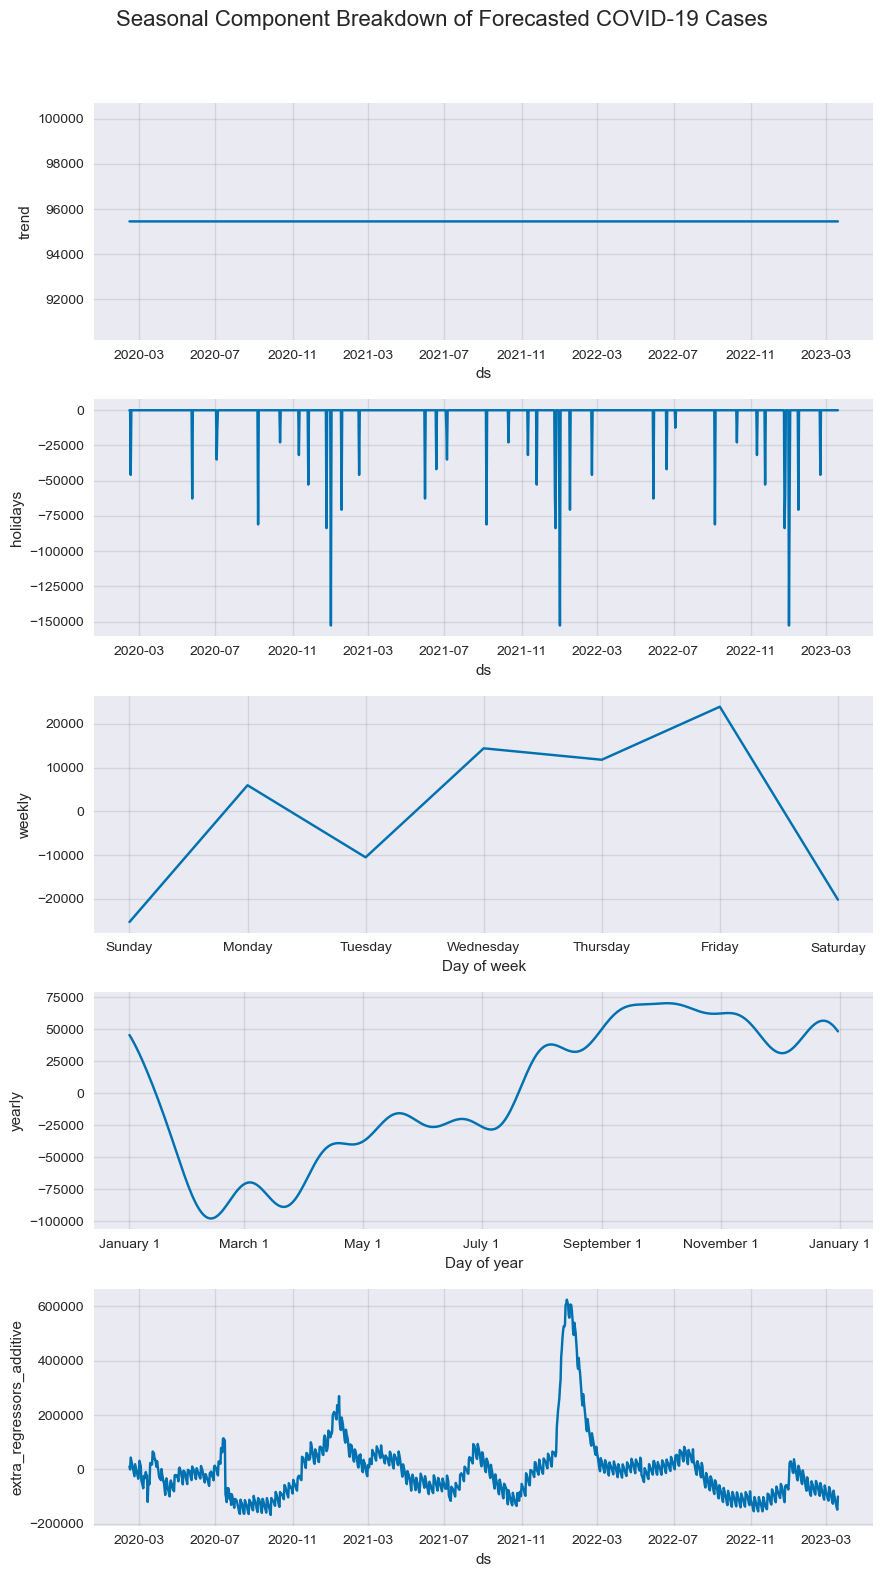

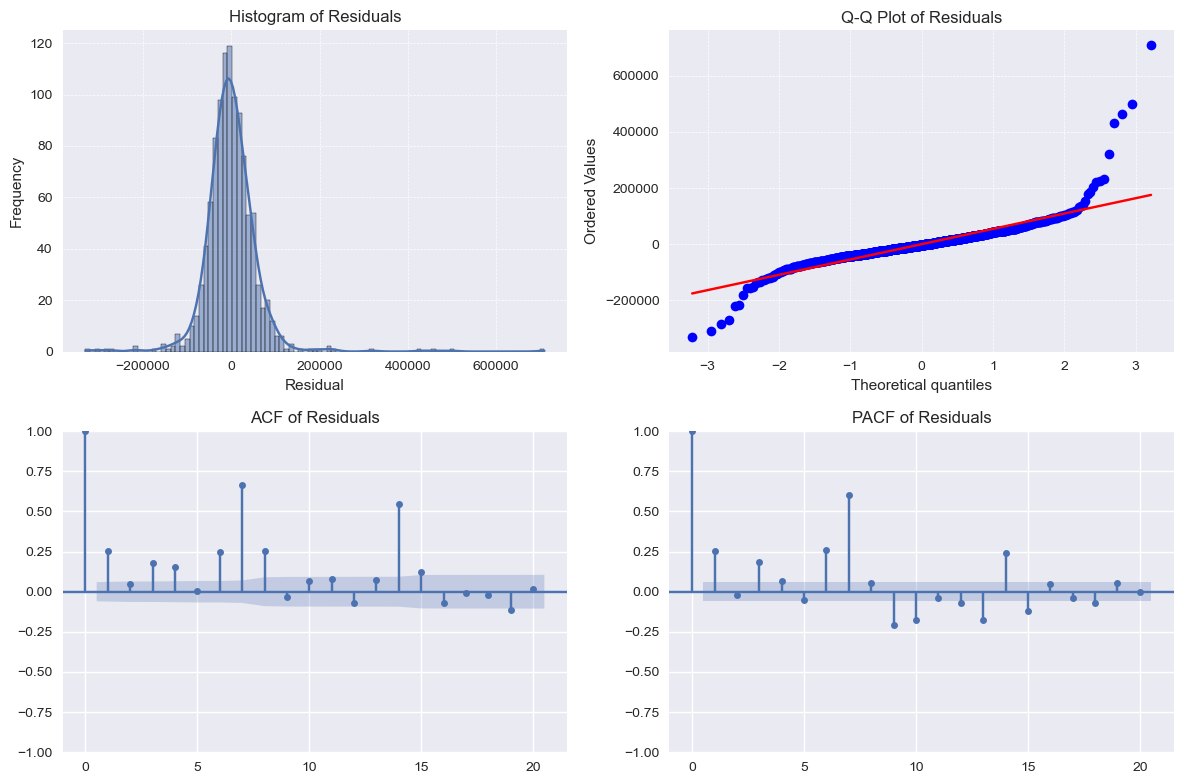

TypeError: 'list' object is not callable

In [ ]:

forecast_df = forecast_df_complete(model3, y_train, y_test, big_ready)

# Generate the Prophet forecast plot
fig = plot_plotly(model3, forecast_df)
fig.show();

# Add the test actual data points
fig.add_trace(go.Scatter(
    x=y_test.ds, 
    y=y_test.y, 
    mode='lines', 
    name='Historical Predictions', 
    line=dict(color='green')
))

# Add titles and labels
fig.update_layout(
    title=f"{title} Forecast vs Actual Data",
    xaxis_title="Date",
    yaxis_title="Value",
    legend_title="Legend"
)

# Display the plot
fig.show();

fig = model3.plot_components(forecast_df)
fig.suptitle('Seasonal Component Breakdown of Forecasted COVID-19 Cases', y=1.05, fontsize=16)
fig.show();

# Using the function on the sample dataframe
in_sample_eval_holder[f'{title} Prophet Model'] = residual_plotter(forecast_df.dropna(subset='y_train'), yhat_col='yhat', original_col='y_train')



df_cv = cross_validation(
    model3, 
    initial=f"366 days", 
    period=f"{cutoff_period_prediction} days", 
    horizon=f"{cutoff_period_prediction} days",
    parallel="processes")

val_eval_holder[f'{title} Prophet Model'] = pd.to_numeric(performance_metrics(df_cv).mean().drop(index='horizon'))

plot_cross_validation_metric(df_cv, metric='rmse')

plt.title(f'RMSE for COVID-19 Forecasting using {title} Prophet Model');



out_of_sample_eval_holder[f'{title} Prophet Model'] = residual_plotter(forecast_df.dropna(subset='y_test'), yhat_col='yhat', original_col='y_test')


# with open('serialized_model.json', 'w') as fout:
#     fout.write(model_to_json(model3))  # Save model3

# with open('serialized_model.json', 'r') as fin:
#     model3 = model_from_json(fin.read())  # Load model3


In [ ]:

display(val_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
display(in_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
display(out_of_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))

Validation Metric,Base Prophet Model,Tuned Prophet Model,Prophet Super Tuned and Insanity Large Exogenous Model 3 Prophet Model
mse,28160621499.734882,26365675445.739998,2240883.783884
rmse,153148.176498,147088.321667,1347.553028
mae,108432.555908,104166.787212,497.621850
mdape,1.038325,1.011090,0.000023
smape,0.900018,0.901866,0.022001
coverage,0.489807,0.465840,0.818457


In-Sample Metric,Base Prophet Model,Tuned Prophet Model,Prophet Super Tuned and Insanity Large Exogenous Model 3 Prophet Model
R2,0.593939,0.601912,1.000000
MAE,51705.436286,50744.964617,0.174190
RMSE,83698.449913,82872.623110,0.231571
SMAPE,73.923349,73.046986,1.918560


Out-of-Sample Metric,Base Prophet Model,Tuned Prophet Model,Prophet Super Tuned and Insanity Large Exogenous Model 3 Prophet Model
R2,-27.319518,-22.505439,1.000000
MAE,179963.921717,164505.066283,1.055559
RMSE,196781.575449,179277.461048,1.143917
SMAPE,180.610781,179.363791,0.020482


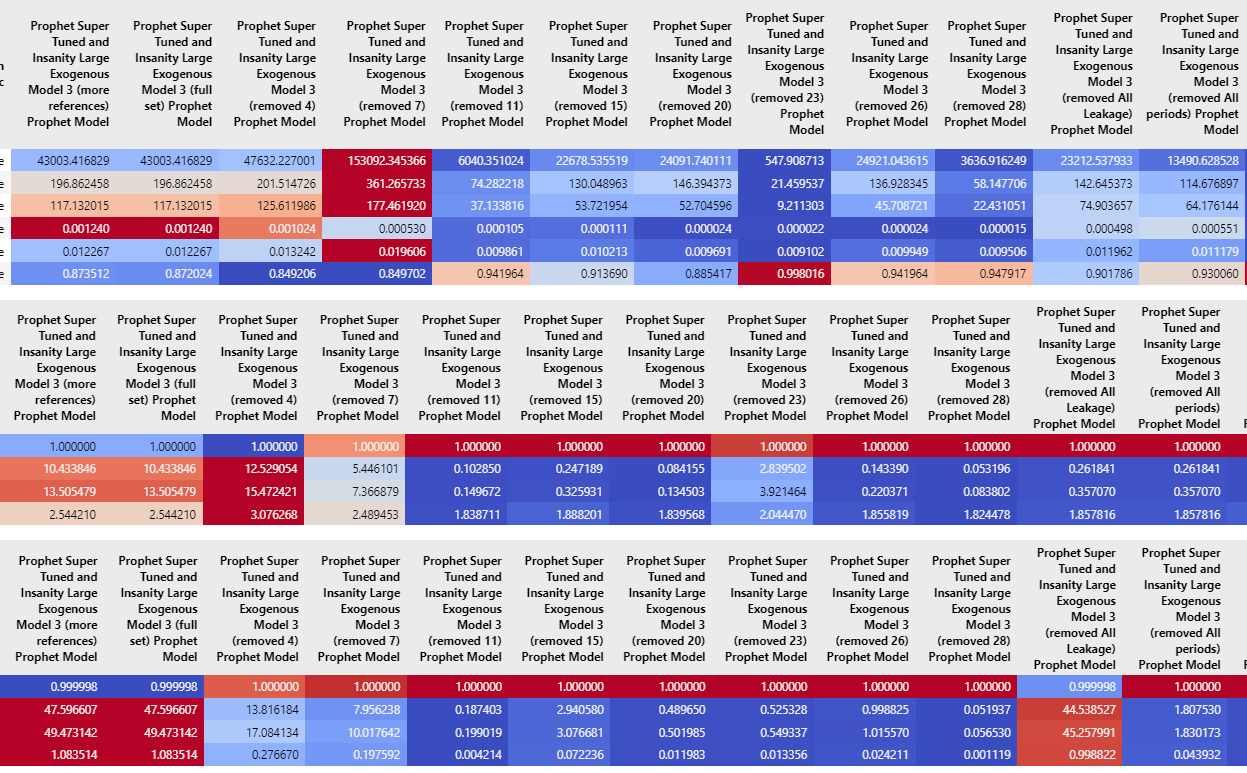 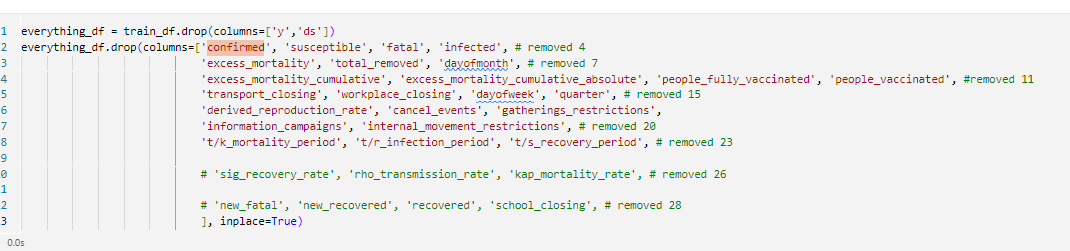